In [0]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import completeness_score
from sklearn.metrics.cluster import v_measure_score
from sklearn.preprocessing import StandardScaler
from munkres import Munkres
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.utils.linear_assignment_ import linear_assignment
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from sklearn.cluster import DBSCAN
from keras.applications.resnet50 import preprocess_input
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
Using TensorFlow backend.


In [0]:
!pip3 install munkres

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv(r'/content/drive/My Drive/Proiect PML/DataSet/sign_mnist_train.csv')
a = np.array(df.duplicated()).astype('int')
print('Dataset shape: ', df.shape)
print('Number of duplicate images: ', a.sum())

Dataset shape:  (27455, 785)
Number of duplicate images:  0


In [0]:
df.head(5)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 164.4 MB


In [0]:
c = df['label'].unique()
c.sort()

print("Total missing values: {}".format(df.isna().sum().sum()),'\n')
print("Classes to predict: {}".format(c),'\n')
#print("Total number of classes: {}.".format(nr_classes),'\n')

Total missing values: 0 

Classes to predict: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 



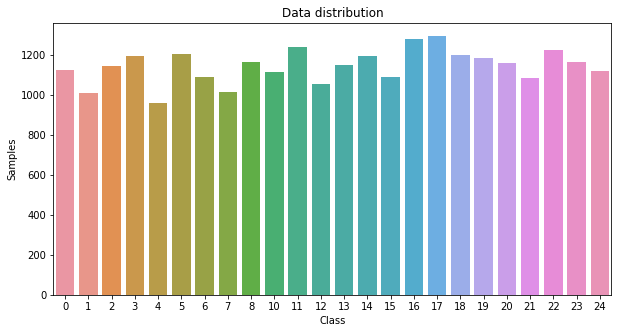

In [0]:
f, ax = plt.subplots(figsize=(10,5))
ax = sns.countplot(x='label', data = df)
plt.xlabel('Class')
plt.ylabel('Samples')
plt.title('Data distribution')
plt.show()

In [4]:
scaler = StandardScaler() 
X = np.array(df.drop('label', axis = 1))
Y = np.array(df['label'])
Y[Y > 8] -= 1
print(np.unique(Y))
nr_classes = max(Y) + 1
print(nr_classes)

X = scaler.fit_transform(X)

print('X shape: ', X.shape)
print('Y shape: ',Y.shape)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
24
X shape:  (27455, 784)
Y shape:  (27455,)


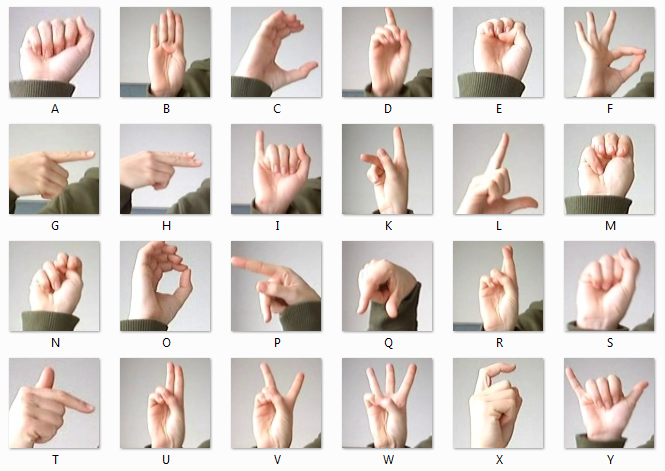

In [0]:
Image(r'/content/drive/My Drive/Proiect PML/DataSet/sign_mnist_examples.png')

In [0]:
def make_cost_matrix(c1, c2):
  
    uc1 = np.unique(c1)
    uc2 = np.unique(c2)

    l1 = uc1.size
    l2 = uc2.size

    assert(l1 == l2 and np.all(uc1 == uc2))

    m = np.ones([l1, l2])
    for i in range(l1):
        it_i = np.nonzero(c1 == uc1[i])[0]
        for j in range(l2):
            it_j = np.nonzero(c2 == uc2[j])[0]
            m_ij = np.intersect1d(it_j, it_i)
            m[i,j] =  -m_ij.size
    return m

In [0]:
def accuracy(cm):
    return np.trace(cm, dtype=float) / np.sum(cm)

In [0]:
def translate_clustering(clt, mapper):
    return np.array([ mapper[i] for i in clt ])

In [0]:
def get_accuracy(predicted, ground_truth):

  cost_matrix = make_cost_matrix(predicted, ground_truth)

  m = Munkres()
  indexes = m.compute(cost_matrix)
  print(type(indexes))
  mapper = { old: new for (old, new) in indexes }

  '''for old, new in mapper.items():
      print("map: %s --> %s" %(old, new))'''

  new_labels = translate_clustering(predicted, mapper)
  new_cm = confusion_matrix(Y, new_labels)

  return accuracy(new_cm)





# K-Means

**Default model**

In [0]:
default_kmeans = KMeans(n_clusters = nr_classes, max_iter = 10000, n_init = 30).fit(X)    

In [0]:
pca = PCA(n_components = 2).fit(X)

reduced_X = pca.transform(X)

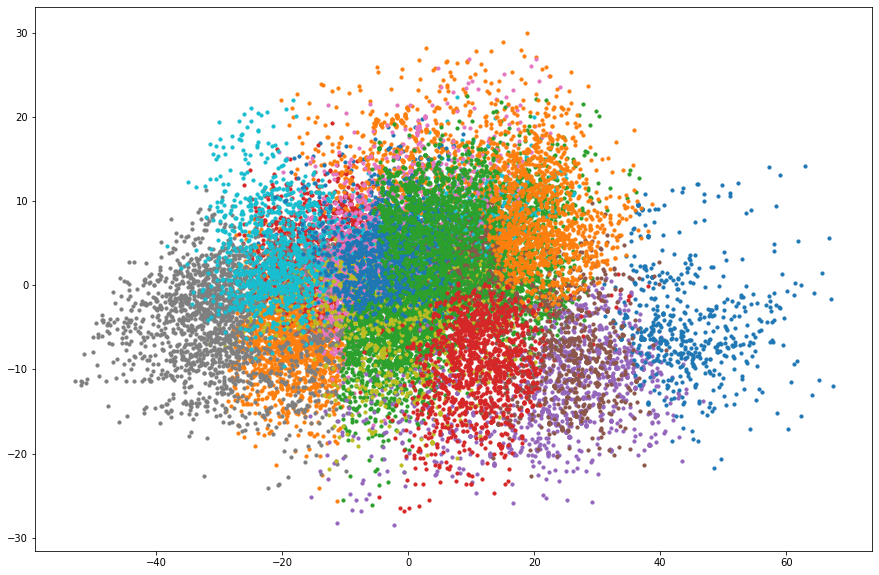

In [0]:
labels_pred = default_kmeans.labels_
plt.figure(figsize=(15, 10))
for i in range(nr_classes):
  plt.scatter(reduced_X[labels_pred == i,0], reduced_X[labels_pred == i,1], s = 10)


In [0]:
acc_hung = get_accuracy(labels_pred, Y)
silhouette_avg = silhouette_score(X, labels_pred)

print("Best accuracy: ", acc_hung)
print('Homogeneity: ',homogeneity_score(Y, labels_pred))
print('Completeness: ',completeness_score(Y, labels_pred))
print('V_measure: ',v_measure_score(Y, labels_pred))
print("The average silhouette_score is :", silhouette_avg)
print("Inertia cost: ", default_kmeans.inertia_)

<class 'list'>
Best accuracy:  0.16973228920050992
Homogeneity:  0.22252091363985146
Completeness:  0.23359919418143882
V_measure:  0.22792551884230058
The average silhouette_score is : 0.06045691146185163
Inertia cost:  10813981.339707281


**Hyper-parameters tuning**

Evaluation of KMeans with k-means++ init and auto alg
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
Evaluation of KMeans with k-means++ init and full alg
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
Evaluation of KMeans with k-means++ init and elkan alg
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


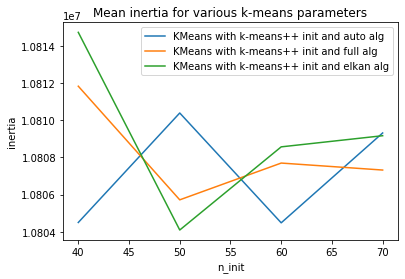

In [0]:
plt.figure()
plots = []
legends = []
acc_list = []
silhoutte_list = []
n_init_range = np.array([40,50,60,70])
cases = [
    (KMeans, 'k-means++', 'auto',{}),
    (KMeans, 'k-means++', 'full',{}),
    (KMeans, 'k-means++', 'elkan',{})
]
for factory, init, alg, params in cases:
    print("Evaluation of %s with %s init and %s alg" % (factory.__name__, init,alg))
    inertia = np.empty((len(n_init_range)))
    acc = []
    sil = []

    for i, n_init in enumerate(n_init_range):
            kmeans = factory(n_clusters=nr_classes, init=init, algorithm = alg,
                         n_init=n_init, **params).fit(X)
            inertia[i] = kmeans.inertia_
            acc.append(get_accuracy(kmeans.labels_, Y))
            sil.append(silhouette_score(X, kmeans.labels_))
    p = plt.plot(n_init_range, inertia, label = "%s with %s init and %s alg" % (factory.__name__, init, alg))
    plots.append(p[0])
    acc_list.append(acc)
    silhoutte_list.append(sil)
    #legends.append("%s with %s init and %s alg" % (factory.__name__, init, alg))

plt.xlabel('n_init')
plt.ylabel('inertia')
plt.legend(loc = "best")
plt.title("Mean inertia for various k-means parameters")
plt.show()

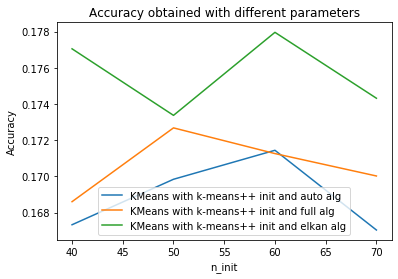

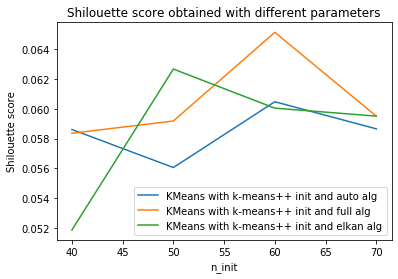

Acc:  [[0.16732835549080313, 0.16984155891458752, 0.17144418138772538, 0.16703696958659625], [0.16860316882170825, 0.17268257148060462, 0.17126206519759607, 0.1700236751047168], [0.1770533600437079, 0.17337461300309598, 0.1779639409943544, 0.17432161719176834]] 

Silouetthe:  [[0.05861929280100631, 0.0560601586595247, 0.060486561617187164, 0.058662433413750756], [0.05836835748210328, 0.05919005921515609, 0.06515385707169119, 0.05951634232451719], [0.05185843733140344, 0.0626834186678068, 0.06005469601008161, 0.05951880428581848]] 



In [0]:
i = 0
plt.figure()
for factory, init, alg, params in cases:
      plt.plot(n_init_range, acc_list[i], label = "%s with %s init and %s alg" % (factory.__name__, init, alg))
      i += 1
      plt.xlabel('n_init')
      plt.ylabel('Accuracy')
      plt.title('Accuracy obtained with different parameters')


plt.legend(loc="best")
plt.show()

plt.figure()
i = 0
for factory, init, alg, params in cases:
      plt.plot(n_init_range, silhoutte_list[i], label = "%s with %s init and %s alg" % (factory.__name__, init, alg))
      i += 1
      plt.xlabel('n_init')
      plt.ylabel('Shilouette score')
      plt.title('Shilouette score obtained with different parameters')


plt.legend(loc="best")
plt.show()



print("Acc: ", acc_list,'\n')
print("Silouetthe: ", silhoutte_list,'\n')

**Dimension reduction with PCA**

In [0]:
pca = PCA(n_components = 300).fit(X)
X_reduced = pca.transform(X)
pca_kmeans = KMeans(n_clusters = nr_classes, init = 'k-means++', max_iter = 10000, n_init = 50).fit(X_reduced)
labels_pca = pca_kmeans.labels_    

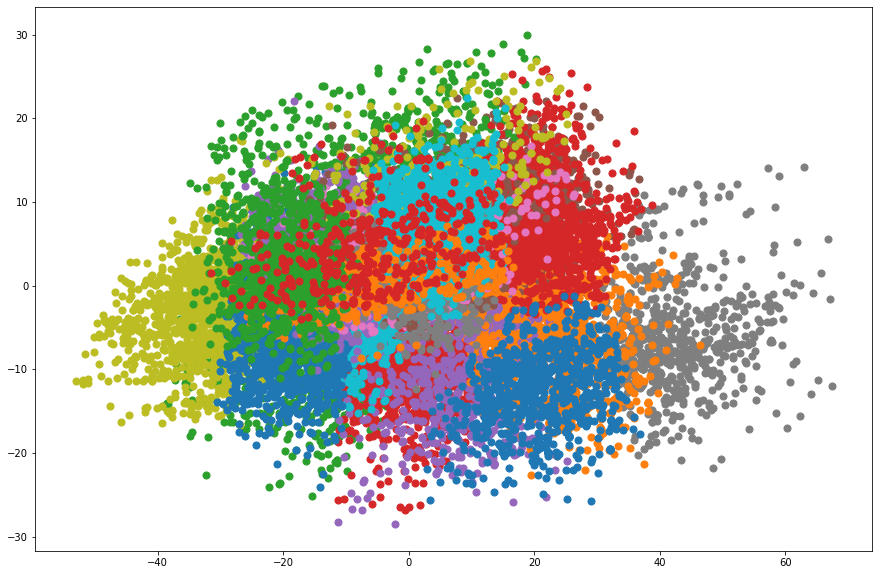

In [36]:
plt.figure(figsize=(15, 10))
for i in range(nr_classes):
  plt.scatter(reduced_X[labels_pca == i,0], reduced_X[labels_pca == i,1], s = 50)

In [37]:
acc_hung = get_accuracy(labels_pca, Y)
silhouette_avg = silhouette_score(X_reduced, labels_pca)

print("Best accuracy: ", acc_hung)
print('Homogeneity: ',homogeneity_score(Y, labels_pca))
print('Completeness: ',completeness_score(Y, labels_pca))
print('V_measure: ',v_measure_score(Y, labels_pca))
print("The average silhouette_score is :", silhouette_avg)
print("Inertia cost: ", pca_kmeans.inertia_)

<class 'list'>
Best accuracy:  0.16907667091604445
Homogeneity:  0.2192493241944928
Completeness:  0.2264203232473765
V_measure:  0.22277713163026655
The average silhouette_score is : 0.05530812109804951
Inertia cost:  10611409.47169633


**Hyper-parameters tuning**


Evaluation of KMeans with k-means++ init and elkan alg
<class 'list'>
<class 'list'>
Evaluation of KMeans with k-means++ init and full alg
<class 'list'>
<class 'list'>


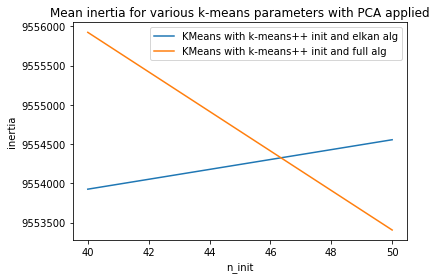

In [0]:
plt.figure()
plots = []
legends = []
acc_list = []
silhoutte_list = []
n_init_range = np.array([40,50])
cases = [
    (KMeans, 'k-means++', 'elkan',{}),
    (KMeans, 'k-means++', 'full',{})
]
for factory, init, alg, params in cases:
    print("Evaluation of %s with %s init and %s alg" % (factory.__name__, init,alg))
    inertia = np.empty((len(n_init_range)))
    acc = []
    sil = []

    for i, n_init in enumerate(n_init_range):
            kmeans = factory(n_clusters=nr_classes, init=init, algorithm = alg,
                         n_init=n_init, **params).fit(X_reduced)
            inertia[i] = kmeans.inertia_
            acc.append(get_accuracy(kmeans.labels_, Y))
            sil.append(silhouette_score(X_reduced, kmeans.labels_))
    p = plt.plot(n_init_range, inertia, label = "%s with %s init and %s alg" % (factory.__name__, init, alg))
    acc_list.append(acc)
    silhoutte_list.append(sil)
    #legends.append("%s with %s init and %s alg" % (factory.__name__, init, alg))

plt.xlabel('n_init')
plt.ylabel('inertia')
plt.legend(loc = "best")
plt.title("Mean inertia for various k-means parameters with PCA applied")
plt.show()

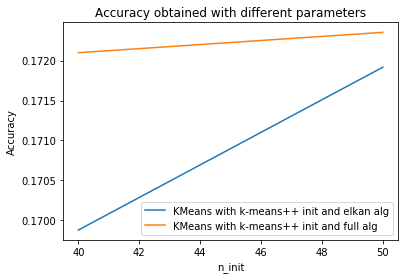

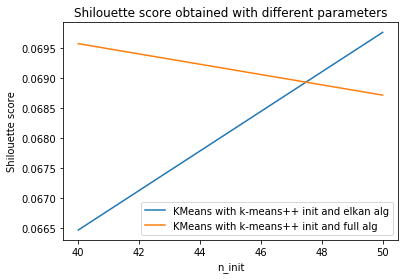

Acc:  [[0.16987798215261338, 0.17191768348206155], [0.17209979967219086, 0.17235476233837188]] 

Silouetthe:  [[0.06646868580554383, 0.06976373965623392], [0.06957508995572632, 0.06871705965399927]] 



In [0]:
i = 0
plt.figure()
for factory, init, alg, params in cases:
      plt.plot(n_init_range, acc_list[i], label = "%s with %s init and %s alg" % (factory.__name__, init, alg))
      i += 1
      plt.xlabel('n_init')
      plt.ylabel('Accuracy')
      plt.title('Accuracy obtained with different parameters')


plt.legend(loc="best")
plt.show()

plt.figure()
i = 0
for factory, init, alg, params in cases:
      plt.plot(n_init_range, silhoutte_list[i], label = "%s with %s init and %s alg" % (factory.__name__, init, alg))
      i += 1
      plt.xlabel('n_init')
      plt.ylabel('Shilouette score')
      plt.title('Shilouette score obtained with different parameters')


plt.legend(loc="best")
plt.show()



print("Acc: ", acc_list,'\n')
print("Silouetthe: ", silhoutte_list,'\n')

**Using a pretrained CNN**

In [22]:
model = VGG16(include_top=False, input_shape=(32,32,3))
img_resized = []
for img in X:
  im = np.pad(img.reshape(28,-1), 2, mode='constant')
  im = np.repeat(im[..., np.newaxis], 3, -1)
  img_resized.append(im)

  #resnet_features.append(np.array(model.predict(im)).flatten())
img_resized = np.array(img_resized)
vgg_features = np.array(model.predict(img_resized))






58892288/58889256 [==============================] - 1s 0us/step








In [23]:
vgg_features = vgg_features.reshape(vgg_features.shape[0], -1)
print(vgg_features.shape)

(27455, 512)


In [0]:
vgg_kmeans = KMeans(n_clusters = nr_classes, max_iter = 5000, init = 'k-means++', n_init = 50).fit(vgg_features)
labels_vgg = vgg_kmeans.labels_    

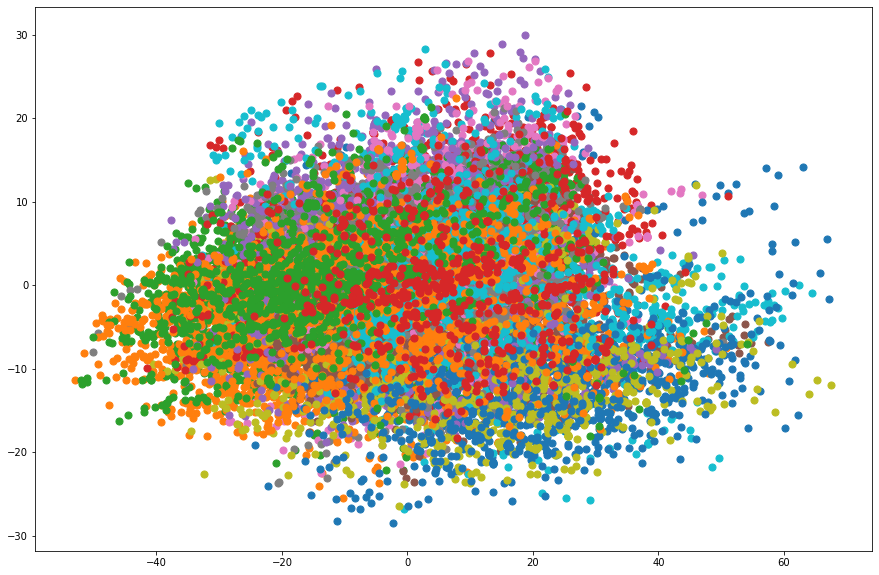

In [0]:
plt.figure(figsize=(15, 10))
for i in range(nr_classes):
  plt.scatter(reduced_X[labels_vgg == i,0], reduced_X[labels_vgg == i,1], s = 50)

In [0]:
acc_hung = get_accuracy(labels_vgg, Y)
silhouette_avg = silhouette_score(vgg_features, labels_resnet)

print("Best accuracy: ", acc_hung)
print('Homogeneity: ',homogeneity_score(Y, labels_vgg))
print('Completeness: ',completeness_score(Y, labels_vgg))
print('V_measure: ',v_measure_score(Y, labels_vgg))
print("The average silhouette_score is :", silhouette_avg)
print("Inertia cost: ", vgg_kmeans.inertia_)

<class 'list'>
Best accuracy:  0.28679657621562554
Homogeneity:  0.3726292934248094
Completeness:  0.37984083420366
V_measure:  0.3762005067477842
The average silhouette_score is : 0.072797395
Inertia cost:  546628.9823086819


**Hyper-parameters tuning**

Evaluation of KMeans with k-means++ init and auto alg
<class 'list'>
<class 'list'>
Evaluation of KMeans with k-means++ init and full alg
<class 'list'>
<class 'list'>


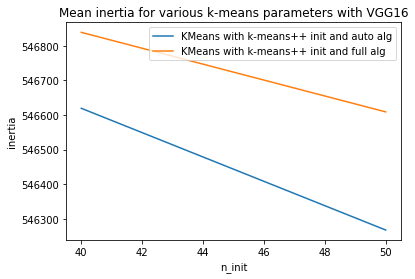

In [0]:
plt.figure()
plots = []
legends = []
acc_list = []
silhoutte_list = []
n_init_range = np.array([40,50])
cases = [
    (KMeans, 'k-means++', 'auto',{}),
    (KMeans, 'k-means++', 'full',{})
]
for factory, init, alg, params in cases:
    print("Evaluation of %s with %s init and %s alg" % (factory.__name__, init,alg))
    inertia = np.empty((len(n_init_range)))
    acc = []
    sil = []

    for i, n_init in enumerate(n_init_range):
            kmeans = factory(n_clusters=nr_classes, init=init, algorithm = alg,
                         n_init=n_init, **params).fit(vgg_features)
            inertia[i] = kmeans.inertia_
            acc.append(get_accuracy(kmeans.labels_, Y))
            sil.append(silhouette_score(vgg_features, kmeans.labels_))
    p = plt.plot(n_init_range, inertia, label = "%s with %s init and %s alg" % (factory.__name__, init, alg))
    acc_list.append(acc)
    silhoutte_list.append(sil)
    #legends.append("%s with %s init and %s alg" % (factory.__name__, init, alg))

plt.xlabel('n_init')
plt.ylabel('inertia')
plt.legend(loc = "best")
plt.title("Mean inertia for various k-means parameters with VGG16")
plt.show()

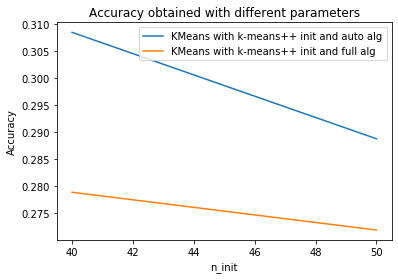

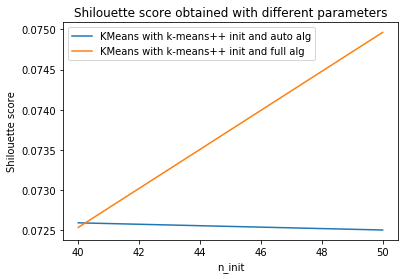

Acc:  [[0.3085412493170643, 0.28883627754507374], [0.2789291568020397, 0.27193589510107447]] 

Silouetthe:  [[0.07259454, 0.07250525], [0.07253781, 0.07496418]] 



In [0]:
i = 0
plt.figure()
for factory, init, alg, params in cases:
      plt.plot(n_init_range, acc_list[i], label = "%s with %s init and %s alg" % (factory.__name__, init, alg))
      i += 1
      plt.xlabel('n_init')
      plt.ylabel('Accuracy')
      plt.title('Accuracy obtained with different parameters')


plt.legend(loc="best")
plt.show()

plt.figure()
i = 0
for factory, init, alg, params in cases:
      plt.plot(n_init_range, silhoutte_list[i], label = "%s with %s init and %s alg" % (factory.__name__, init, alg))
      i += 1
      plt.xlabel('n_init')
      plt.ylabel('Shilouette score')
      plt.title('Shilouette score obtained with different parameters')


plt.legend(loc="best")
plt.show()



print("Acc: ", acc_list,'\n')
print("Silouetthe: ", silhoutte_list,'\n')

# DBScan

**Default model**

In [0]:
db_default = DBSCAN().fit(X)
core_samples_mask = np.zeros_like(db_default.labels_, dtype=bool)
core_samples_mask[db_default.core_sample_indices_] = True
labels_dbdefault = db_default.labels_

n_clusters_ = len(set(labels_dbdefault)) - (1 if -1 in labels_dbdefault else 0)
n_noise_ = list(labels_dbdefault).count(-1)


In [0]:
print('Estimated number of clusters: ' , n_clusters_)
print('Estimated number of noise points: ', n_noise_)
print("Homogeneity: ", homogeneity_score(Y, labels_dbdefault))
print("Completeness: ", completeness_score(Y, labels_dbdefault))
print("V-measure: ", v_measure_score(Y, labels_dbdefault))
print("Adjusted Rand Index: ", adjusted_rand_score(Y, labels_dbdefault))
#print("Silhouette Coefficient: ", silhouette_score(X, labels_dbdefault))

Estimated number of clusters:  1
Estimated number of noise points:  0
Homogeneity:  -2.185163089516763e-16
Completeness:  1.0
V-measure:  -4.370326179033527e-16
Adjusted Rand Index:  0.0


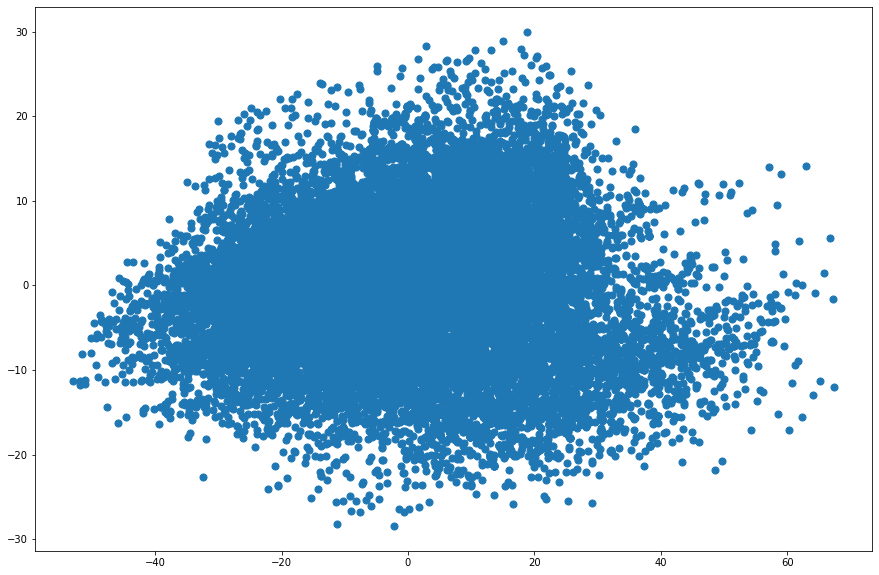

In [0]:
plt.figure(figsize=(15, 10))
for i in range(nr_classes):
  plt.scatter(reduced_X[labels_dbdefault == i,0], reduced_X[labels_dbdefault == i,1], s = 50)


**Choosing the optimal value for epsilon**


In [0]:
nn_model = NearestNeighbors(n_neighbors=2)
neighbours = nn_model.fit(X)
distances, indices = neighbours.kneighbors(X)

In [13]:
print(distances.shape)

(27455, 2)


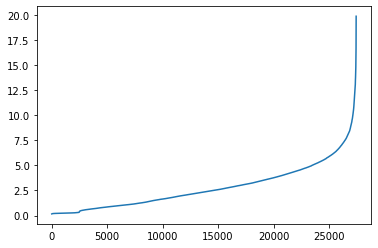

In [14]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

**Hyperparameter tuning**

In [0]:
min_samples = np.arange(5,50,10)
eps = 7
adj_rand = []
n_clst = []

for sample in min_samples:
  dbscan_model = DBSCAN(eps= eps, min_samples = sample).fit(X)
  adj_rand.append(adjusted_rand_+score(Y, dbscan_model.labels_))
  n_clst.append(len(set(dbscan_model.labels_)) - (1 if -1 in dbscan_model.labels_ else 0))




No handles with labels found to put in legend.


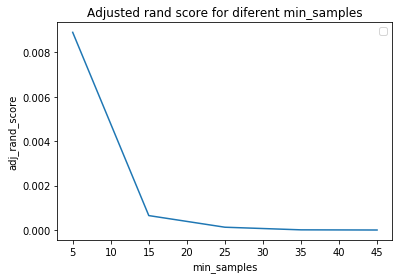

No handles with labels found to put in legend.


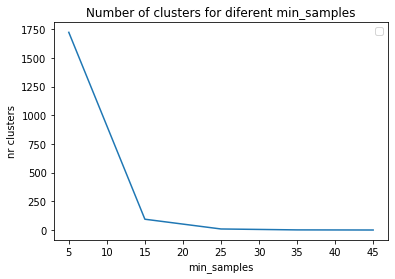

clusters:  [1722, 94, 9, 1, 0]
adj rand scores:  [0.008906107699229704, 0.0006498570500702714, 0.00012592357205602932, 7.464479174926977e-06, 0.0]


In [20]:
plt.figure()
plt.plot(min_samples, adj_rand)
plt.xlabel('min_samples')
plt.ylabel('adj_rand_score')
plt.legend(loc = "best")
plt.title("Adjusted rand score for diferent min_samples")
plt.show()


plt.figure()
plt.plot(min_samples, n_clst)
plt.xlabel('min_samples')
plt.ylabel('nr clusters')
plt.legend(loc = "best")
plt.title("Number of clusters for diferent min_samples")
plt.show()
print('clusters: ',n_clst)
print('adj rand scores: ', adj_rand)

**Using a pretrained CNN**

In [39]:
dbscan_CNN = DBSCAN(eps = 7.5, min_samples = 25).fit(vgg_features)

core_samples_mask = np.zeros_like(dbscan_CNN.labels_, dtype=bool)
core_samples_mask[dbscan_CNN.core_sample_indices_] = True

n_clusters_ = len(set(dbscan_CNN.labels_)) - (1 if -1 in dbscan_CNN.labels_ else 0)
n_noise_ = list(dbscan_CNN.labels_).count(-1)

print('Estimated number of clusters: ' , n_clusters_)
print('Estimated number of noise points: ', n_noise_)
print("Homogeneity: ", homogeneity_score(Y, dbscan_CNN.labels_))
print("Completeness: ", completeness_score(Y, dbscan_CNN.labels_))
print("V-measure: ", v_measure_score(Y, dbscan_CNN.labels_))
print("Adjusted Rand Index: ", adjusted_rand_score(Y, dbscan_CNN.labels_))

Estimated number of clusters:  1
Estimated number of noise points:  0
Homogeneity:  -2.185163089516763e-16
Completeness:  1.0
V-measure:  -4.370326179033527e-16
Adjusted Rand Index:  0.0


**Dimension reduction with PCA**

In [0]:
pca = PCA(n_components = 300).fit(X)
X_reduced = pca.transform(X)
pca_dbscan = DBSCAN(eps = eps, min_samples = 30).fit(X_reduced)

core_samples_mask = np.zeros_like(pca_dbscan.labels_, dtype=bool)
core_samples_mask[pca_dbscan.core_sample_indices_] = True
labels_dbdefault = pca_dbscan.labels_

n_clusters_ = len(set(labels_dbdefault)) - (1 if -1 in labels_dbdefault else 0)
n_noise_ = list(labels_dbdefault).count(-1)



In [28]:
print('Estimated number of clusters: ' , n_clusters_)
print('Estimated number of noise points: ', n_noise_)
print("Homogeneity: ", homogeneity_score(Y, labels_dbdefault))
print("Completeness: ", completeness_score(Y, labels_dbdefault))
print("V-measure: ", v_measure_score(Y, labels_dbdefault))
print("Adjusted Rand Index: ", adjusted_rand_score(Y, labels_dbdefault))

Estimated number of clusters:  6
Estimated number of noise points:  27249
Homogeneity:  0.007626772270754404
Completeness:  0.4205724025126352
V-measure:  0.014981859500082123
Adjusted Rand Index:  8.540186504507563e-05


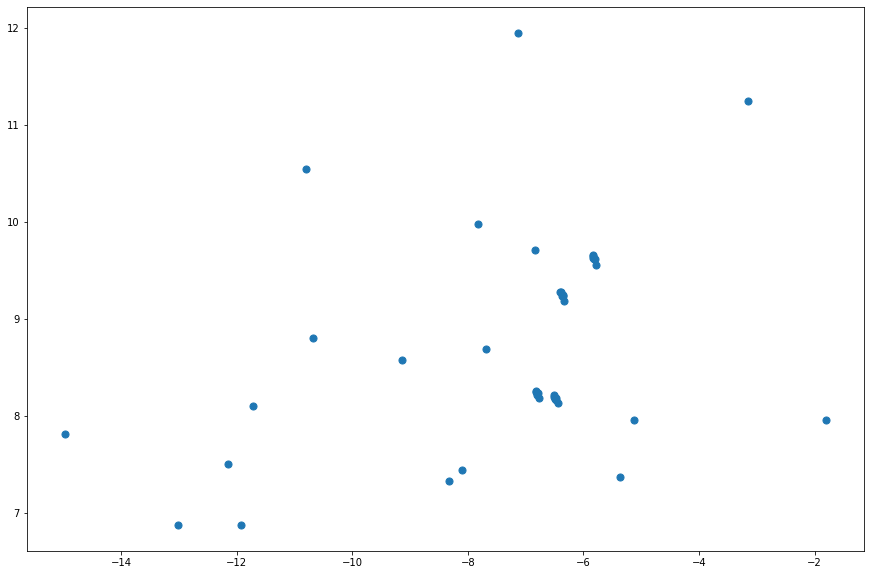

In [41]:
plt.figure(figsize=(15, 10))
for i in range(n_clusters_):
  plt.scatter(reduced_X[pca_dbscan.labels_ == i,0], reduced_X[pca_dbscan.labels_ == i,1], s = 50)